In [6]:
import gymnasium as gym
from gymnasium import spaces
import numpy as np
import math
import torch
import torch.nn as nn
from stable_baselines3 import PPO
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.vec_env import DummyVecEnv, VecNormalize
import matplotlib.pyplot as plt
import os

In [7]:
# PART 0: EMERGENCY SETUP (Ensures code runs even if you lost previous files)
# ==============================================================================
# Define the Architecture (Must match your saved model)
class ClonePolicy(nn.Module):
    def __init__(self):
        super(ClonePolicy, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(4, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 1)
        )
    def forward(self, x):
        return self.net(x)

# Check if model exists, if not, create a dummy one so code doesn't crash
model_path = "models/imitation/lqr_clone.pth"
if not os.path.exists(model_path):
    print("WARNING: 'lqr_clone.pth' not found. Creating a random base model for testing.")
    os.makedirs(os.path.dirname(model_path), exist_ok=True)
    dummy_model = ClonePolicy()
    torch.save(dummy_model.state_dict(), model_path)

In [8]:
# PART 1: HYBRID RESIDUAL ENVIRONMENT
# ==============================================================================
class HybridResidualEnv(gym.Env):
    def __init__(self, base_policy_path):
        super(HybridResidualEnv, self).__init__()
        
        # 1. Load the Base (Imitation) Model
        self.base_policy = ClonePolicy()
        self.base_policy.load_state_dict(torch.load(base_policy_path))
        self.base_policy.eval() # Freeze weights
        
        # 2. Physics Constants
        self.dt = 0.02
        self.force_mag = 10.0
        self.x_threshold = 2.4
        self.theta_threshold_radians = 0.4 # ~23 degrees
        
        # 3. Action Space (Residual Only)
        # We give the RL agent a small range (+/- 2.0 N) to "polish" the result
        self.action_space = spaces.Box(low=-2.0, high=2.0, shape=(1,), dtype=np.float32)
        
        # 4. Observation Space (Standard CartPole)
        high = np.array([np.inf, np.inf, np.inf, np.inf], dtype=np.float32)
        self.observation_space = spaces.Box(-high, high, dtype=np.float32)
        
        self.state = None
        self.initial_side = 0

    def step(self, action):
        x, x_dot, theta, theta_dot = self.state
        
        # --- A. BASE ACTION (Imitation Net) ---
        obs_tensor = torch.tensor(self.state, dtype=torch.float32).unsqueeze(0)
        with torch.no_grad():
            u_base = self.base_policy(obs_tensor).item()
            
        # --- B. RESIDUAL ACTION (RL Agent) ---
        u_residual = action[0]
        
        # --- C. COMBINE ---
        total_force = np.clip(u_base + u_residual, -self.force_mag, self.force_mag)
        
        # --- D. PHYSICS DYNAMICS ---
        costheta = math.cos(theta)
        sintheta = math.sin(theta)
        temp = (total_force + 0.05 * theta_dot**2 * sintheta) / 1.1
        thetaacc = (9.8 * sintheta - costheta * temp) / (0.5 * (4.0/3.0 - 0.1 * costheta**2 / 1.1))
        xacc = temp - 0.05 * thetaacc * costheta / 1.1
        
        x += self.dt * x_dot
        x_dot += self.dt * xacc
        theta += self.dt * theta_dot
        theta_dot += self.dt * thetaacc
        
        self.state = (x, x_dot, theta, theta_dot)
        
        terminated = bool(abs(x) > self.x_threshold or abs(theta) > self.theta_threshold_radians)
        
        # --- E. REWARD ---
        if not terminated:
            # A. Distance Cost (Standard)
            r_angle = -5.0 * abs(theta) # L1 norm is better for precision near 0 than L2 (square)
            
            # B. The Barrier Penalty (Electric Fence)
            # If start_side is +1 (Positive), current angle MUST NOT be < -0.002
            # We allow a tiny 0.002 margin for float errors.
            r_barrier = 0.0
            
            # Check if we crossed to the other side
            if np.sign(theta) != self.initial_side and abs(theta) > 0.002:
                # HUGE PENALTY for crossing
                r_barrier = -100.0 
                
                # OPTIONAL: Kill the episode immediately if you want it to be a "Hard Constraint"
                # terminated = True 
            
            # C. Velocity Penalty (Braking incentive)
            r_vel = -0.5 * abs(theta_dot)
            
            reward = 1.0 + r_angle + r_barrier + r_vel
        else:
            reward = -20.0

        return np.array(self.state, dtype=np.float32), reward, terminated, False, {
            "u_base": u_base, 
            "u_res": u_residual
        }

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        # Random start around 0.4363 rad (25 degrees)
        self.state = np.array([0.0, 0.0, 0.4363, 0.0]) + self.np_random.uniform(-0.05, 0.05, size=4)
        self.initial_side = np.sign(self.state[2])
        return np.array(self.state, dtype=np.float32), {}

In [9]:
# PART 2: TRAINING THE RESIDUAL AGENT
# ==============================================================================
log_dir = "logs_hybrid"
os.makedirs(log_dir, exist_ok=True)

# 1. Initialize Environment
env = HybridResidualEnv(base_policy_path=model_path)
env = Monitor(env, log_dir)
env = DummyVecEnv([lambda: env])
env = VecNormalize(env, norm_obs=True, norm_reward=True, clip_obs=10.)

# 2. Train PPO
# Low learning rate is key for Residual Learning (fine-tuning)
model = PPO("MlpPolicy", env, verbose=1, learning_rate=0.0001, n_steps=2048)

print("--- STARTING RESIDUAL TRAINING ---")
model.learn(total_timesteps=30000)
print("--- TRAINING COMPLETE ---")

Using cuda device
--- STARTING RESIDUAL TRAINING ---
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1        |
|    ep_rew_mean     | -20      |
| time/              |          |
|    fps             | 578      |
|    iterations      | 1        |
|    time_elapsed    | 3        |
|    total_timesteps | 2048     |
---------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1            |
|    ep_rew_mean          | -20          |
| time/                   |              |
|    fps                  | 510          |
|    iterations           | 2            |
|    time_elapsed         | 8            |
|    total_timesteps      | 4096         |
| train/                  |              |
|    approx_kl            | 0.0075283945 |
|    clip_fraction        | 0.0298       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.42        |
|    


--- RUNNING VISUALIZATION ---


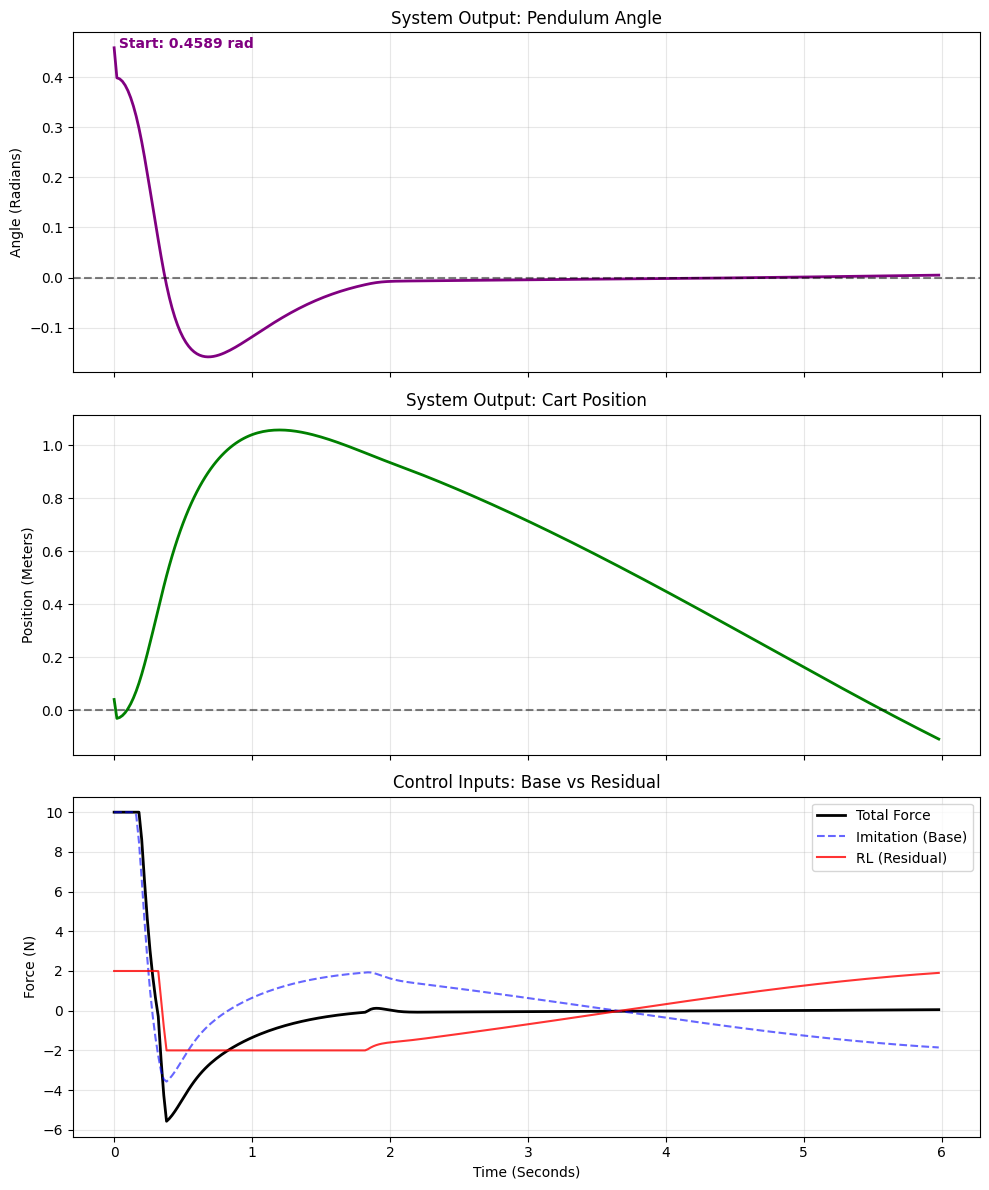

In [10]:
# PART 3: VISUALIZATION (FIXED)
# ==============================================================================
print("\n--- RUNNING VISUALIZATION ---")

# 1. Reset Environment
obs = env.reset()

# 2. FORCE INITIAL STATE (The Fix)
# We want to start exactly at 0.4363 rad (approx 25 degrees)
target_angle = 0.4363
initial_state = np.array([0.0, 0.0, target_angle, 0.0], dtype=np.float32)

# [CRITICAL] Update the Physics Engine
# .envs[0] accesses the first env in DummyVecEnv
# .unwrapped accesses the raw HybridResidualEnv (stripping wrappers)
env.envs[0].unwrapped.state = initial_state 

# [CRITICAL] Update the Agent's View (obs)
# Since we hacked the physics, we must hack the observation so the agent sees it.
raw_obs = np.array([initial_state], dtype=np.float32)
obs = env.normalize_obs(raw_obs)

# 3. Retrieve dt for Time Axis
delta_t = 0.02 # Known constant

# 4. Run Simulation
history_time = []
history_angle = []
history_pos = []
history_base = []
history_res = []
history_total = []

for i in range(300): # 6 seconds
    # Predict
    action, _ = model.predict(obs, deterministic=True)
    action = np.clip(action, -2.0, 2.0) # Ensure within residual bounds
    # Step
    obs, reward, done, info_list = env.step(action)
    info = info_list[0]
    
    # Capture Real Physics (Unwrapped)
    raw_state = env.envs[0].unwrapped.state
    
    history_time.append(i * delta_t)
    history_pos.append(raw_state[0])
    history_angle.append(raw_state[2])
    history_base.append(np.clip(info['u_base'], -env.envs[0].unwrapped.force_mag, env.envs[0].unwrapped.force_mag))
    history_res.append(info['u_res'])
    history_total.append(np.clip(info['u_base'] + info['u_res'], -env.envs[0].unwrapped.force_mag, env.envs[0].unwrapped.force_mag))
    
    if done:
        obs = env.reset() # Reset if crashed

# PART 4: PLOTTING
# ==============================================================================
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 12), sharex=True)

# Plot 1: Angle
ax1.plot(history_time, history_angle, color='purple', linewidth=2)
ax1.axhline(0, color='black', linestyle='--', alpha=0.5)
ax1.set_title("System Output: Pendulum Angle")
ax1.set_ylabel("Angle (Radians)")
ax1.grid(True, alpha=0.3)
# Mark the start to prove the fix worked
ax1.text(0, history_angle[0], f" Start: {history_angle[0]:.4f} rad", color='purple', fontweight='bold')

# Plot 2: Position
ax2.plot(history_time, history_pos, color='green', linewidth=2)
ax2.axhline(0, color='black', linestyle='--', alpha=0.5)
ax2.set_title("System Output: Cart Position")
ax2.set_ylabel("Position (Meters)")
ax2.grid(True, alpha=0.3)

# Plot 3: Forces
ax3.plot(history_time, history_total, color='black', linewidth=2, label='Total Force')
ax3.plot(history_time, history_base, color='blue', linestyle='--', alpha=0.6, label='Imitation (Base)')
ax3.plot(history_time, history_res, color='red', alpha=0.8, label='RL (Residual)')
ax3.set_title("Control Inputs: Base vs Residual")
ax3.set_ylabel("Force (N)")
ax3.set_xlabel("Time (Seconds)")
ax3.legend()
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()